# Catboost Regression Predictions

AFKATM, Uton Hackathon 2019

<img src="image.png" width="420" height="200">

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load the clean data set

In [2]:
df = pd.read_csv('data_clean.csv')
df = df.set_index('date')
df.index = df.index.astype('datetime64')

In [3]:
df.head()

,atm_name,withdrawals_total,withdrawals_xyz,withdrawals_other,amount_total,amount_xyz,amount_other,weekday,festival,working_day
date,,,,,,,,,,
2011-01-01,KK Nagar ATM,265.0,159.0,106.0,945300.0,532600.0,412700.0,6,C,0.0
2011-01-01,Airport ATM,98.0,56.0,42.0,503400.0,347700.0,155700.0,6,C,0.0
2011-01-01,Christ College ATM,74.0,25.0,49.0,287700.0,148200.0,139500.0,6,C,0.0
2011-01-01,Big Street ATM,50.0,20.0,30.0,123800.0,41700.0,82100.0,6,H,0.0
2011-01-01,Mount Road ATM,253.0,67.0,186.0,767900.0,270900.0,497000.0,6,C,0.0


## Define a function for generating features out of the existing ones:

- Tomorrow's `amount_total` as target
- Tomorrow's `festival` and `working_day` because we know them beforehand
- Today's `withdrawal_total`, `withdrawal_xyz`, `withdrawal_other`, `amount_total`, `amount_xyz`, `amount_other` and their historical value if necessary
- The average amount per withdrawal in general, for xyz only and for others

In [4]:
# generate features from a temp_df with shift=depth (start from 0!)

def create_historical_features(temp, depth):
    return {
        f'weekday_{depth}': temp.weekday.astype('float').shift(depth - 1),
        f'festival_{depth}': temp.festival.shift(depth - 1),
        f'working_day_{depth}': temp.working_day.astype('float').shift(depth - 1),
        f'withdrawals_total_{depth}': temp.withdrawals_total.astype('float').shift(depth),
        f'withdrawals_xyz_{depth}': temp.withdrawals_xyz.astype('float').shift(depth),
        f'withdrawals_other_{depth}': temp.withdrawals_other.astype('float').shift(depth),
        f'amount_total_{depth}': temp.amount_total.astype('float').shift(depth),
        f'amount_xyz_{depth}': temp.amount_xyz.astype('float').shift(depth),
        f'amount_other_{depth}': temp.amount_other.astype('float').shift(depth),
        f'amount_withdrawals_total_{depth}': temp.amount_total.astype('float').shift(depth) / temp.withdrawals_total.astype('float').shift(depth),
        f'amount_withdrawals_xyz_{depth}': temp.amount_xyz.astype('float').shift(depth) / temp.withdrawals_xyz.astype('float').shift(depth),
        f'amount_withdrawal_other_{depth}': temp.amount_other.astype('float').shift(depth) / temp.withdrawals_other.astype('float').shift(depth),
    }

## Train the models and save the test predictions

In [5]:
def train_atm(atm, df):
    print('\n' + '=' * 50)
    print(atm + '\n')
    
    temp = df[df.atm_name == atm]
    
    features = {
        'target': temp.amount_total.astype('float').shift(-1),
        'atm_name': temp.atm_name
    }
    for depth in range(4):
        features_depth = create_historical_features(temp, depth)
        for key, value in features_depth.items():
            features[key] = value
    
    train_df = pd.DataFrame(features)
    train_df = train_df.sort_index().dropna()
    
    train = train_df[train_df.index <= train_df.index.max() - dt.timedelta(days=365)]
    test = train_df[train_df.index > train_df.index.max() - dt.timedelta(days=365)]

    y_train = list(train.target)
    test_target = test.target
    y_test = list(test_target)

    train = train.reset_index().drop(columns=['target', 'date'])
    test = test.reset_index().drop(columns=['target', 'date'])

    cat_features = [c for c in train.columns if train[c].dtype == 'object']
    
    model = CatBoostRegressor(
        iterations=7000,
        learning_rate=0.002,
        depth=8,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        metric_period=500,
        od_wait=350,
        use_best_model=True,
        cat_features=cat_features,
        l2_leaf_reg=1
    )
    model.fit(
        train, y_train,
        eval_set=(test, y_test)
    )
    test_prediction = model.predict(test)
    
    return model, train_df, test_target, test_prediction

In [7]:
models = {}
test_predictions = {}
test_trues = {}
train_features = {}

for atm in list(set(df.atm_name)):
    model, train_df, test_true, test_prediction = train_atm(atm, df)
    models[atm] = model
    test_predictions[atm] = test_prediction
    test_trues[atm] = test_true
    train_features[atm] = train_df


Christ College ATM

0:	learn: 247258.4004959	test: 366146.5870155	best: 366146.5870155 (0)	total: 24.1ms	remaining: 2m 48s


500:	learn: 199536.3925865	test: 332508.5193488	best: 332508.5193488 (500)	total: 5.92s	remaining: 1m 16s
1000:	learn: 178665.8960007	test: 321371.8087881	best: 321371.8087881 (1000)	total: 11.9s	remaining: 1m 11s
1500:	learn: 166216.1571203	test: 317155.8041335	best: 317155.8041335 (1500)	total: 18s	remaining: 1m 6s
2000:	learn: 157653.6001988	test: 315155.6538019	best: 315152.1465616 (1999)	total: 23.8s	remaining: 59.6s
2500:	learn: 150849.8265433	test: 314230.4559804	best: 314216.1055022 (2480)	total: 29.6s	remaining: 53.3s
3000:	learn: 144976.9276985	test: 313664.3836036	best: 313659.4057615 (2982)	total: 35.3s	remaining: 47s
3500:	learn: 139393.9432229	test: 313201.6472672	best: 313201.6472672 (3500)	total: 41.2s	remaining: 41.1s
4000:	learn: 133872.5778827	test: 313048.1809114	best: 313021.6134884 (3941)	total: 47.1s	remaining: 35.3s
4500:	learn: 128562.9044714	test: 312875.5357379	best: 312875.5357379 (4500)	total: 53s	remaining: 29.4s
5000:	learn: 123163.0004456	test: 312773.89

500:	learn: 162369.0560230	test: 187031.6037228	best: 187031.6037228 (500)	total: 6.95s	remaining: 1m 30s
1000:	learn: 150319.4299592	test: 182863.5265279	best: 182863.5265279 (1000)	total: 14s	remaining: 1m 23s
1500:	learn: 142017.1337245	test: 181429.6920327	best: 181429.6920327 (1500)	total: 21.1s	remaining: 1m 17s
2000:	learn: 135922.6180454	test: 180726.2672640	best: 180717.1529270 (1998)	total: 28.3s	remaining: 1m 10s
2500:	learn: 130720.7279421	test: 180355.1045539	best: 180355.1045539 (2500)	total: 35.3s	remaining: 1m 3s
3000:	learn: 125877.6238353	test: 180122.6420029	best: 180122.6420029 (3000)	total: 42.4s	remaining: 56.5s
3500:	learn: 121195.0911007	test: 179944.0839442	best: 179944.0839442 (3500)	total: 49.6s	remaining: 49.6s
Stopped by overfitting detector  (350 iterations wait)

bestTest = 179918.6908
bestIteration = 3621

Shrink model to first 3622 iterations.

KK Nagar ATM

0:	learn: 424858.0468836	test: 421103.0043790	best: 421103.0043790 (0)	total: 18.6ms	remaining: 

500:	learn: 326648.0792563	test: 340591.5495340	best: 340591.5495340 (500)	total: 6.04s	remaining: 1m 18s
1000:	learn: 288611.6510136	test: 321582.2072790	best: 321582.2072790 (1000)	total: 12.1s	remaining: 1m 12s
1500:	learn: 268255.1078024	test: 316331.2618725	best: 316322.1090790 (1496)	total: 18.2s	remaining: 1m 6s
2000:	learn: 254075.7471325	test: 314705.5297335	best: 314677.3918209 (1991)	total: 24.2s	remaining: 1m
2500:	learn: 242650.4849534	test: 314257.1792435	best: 314219.6491061 (2460)	total: 30.3s	remaining: 54.4s
3000:	learn: 231833.6231101	test: 314060.2514656	best: 314022.3632096 (2972)	total: 36.3s	remaining: 48.4s
Stopped by overfitting detector  (350 iterations wait)

bestTest = 313993.3974
bestIteration = 3137

Shrink model to first 3138 iterations.

Big Street ATM

0:	learn: 153984.8332556	test: 122333.4673168	best: 122333.4673168 (0)	total: 18.8ms	remaining: 2m 11s


500:	learn: 113039.8188153	test: 113680.6517120	best: 113680.6517120 (500)	total: 8.57s	remaining: 1m 51s
1000:	learn: 100180.6363632	test: 113075.6040851	best: 112999.4944185 (914)	total: 17.3s	remaining: 1m 43s
Stopped by overfitting detector  (350 iterations wait)

bestTest = 112999.4944
bestIteration = 914

Shrink model to first 915 iterations.

Mount Road ATM

0:	learn: 234467.2449516	test: 270726.3955174	best: 270726.3955174 (0)	total: 11.8ms	remaining: 1m 22s


500:	learn: 195823.0460822	test: 213332.4176802	best: 213332.4176802 (500)	total: 6.03s	remaining: 1m 18s
1000:	learn: 176884.5204900	test: 197210.6068964	best: 197210.6068964 (1000)	total: 12.1s	remaining: 1m 12s
1500:	learn: 165017.8158865	test: 192581.7063425	best: 192577.2626872 (1498)	total: 18.1s	remaining: 1m 6s
2000:	learn: 156011.1611133	test: 191102.7929643	best: 191090.1144658 (1997)	total: 24.1s	remaining: 1m
2500:	learn: 148473.9271132	test: 190865.6078269	best: 190829.9160110 (2356)	total: 30.1s	remaining: 54.1s
Stopped by overfitting detector  (350 iterations wait)

bestTest = 190829.916
bestIteration = 2356

Shrink model to first 2357 iterations.


## Feature correlation for each model

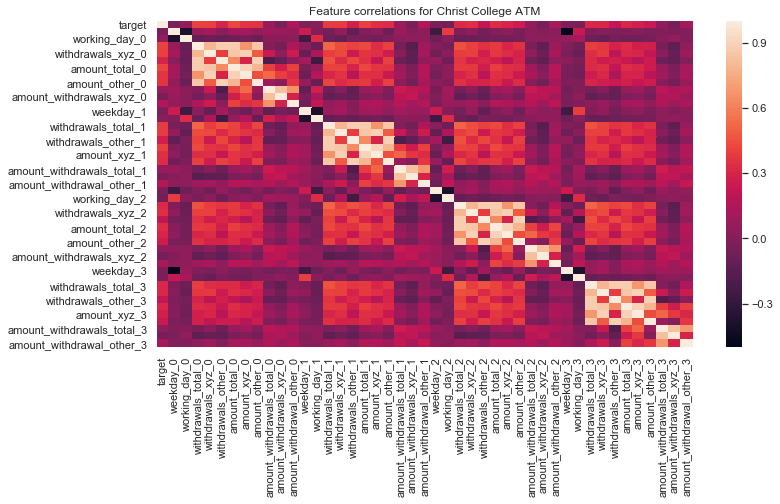

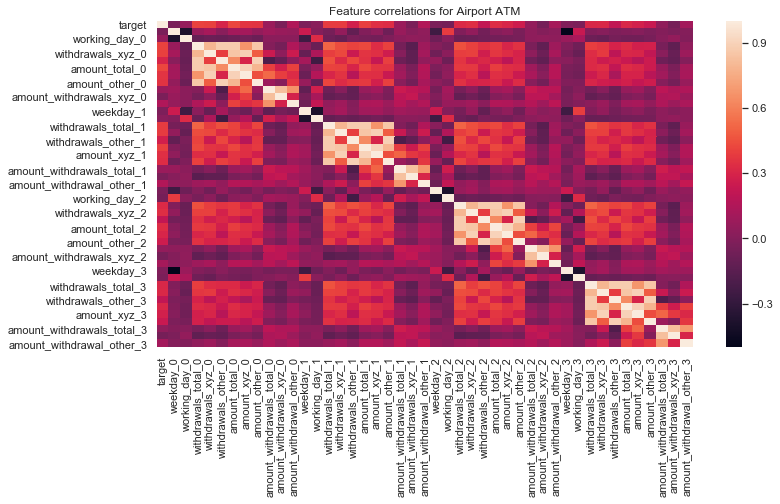

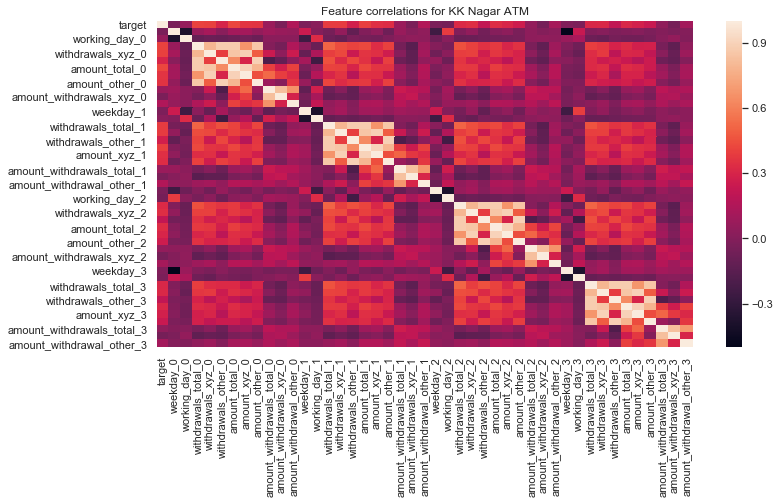

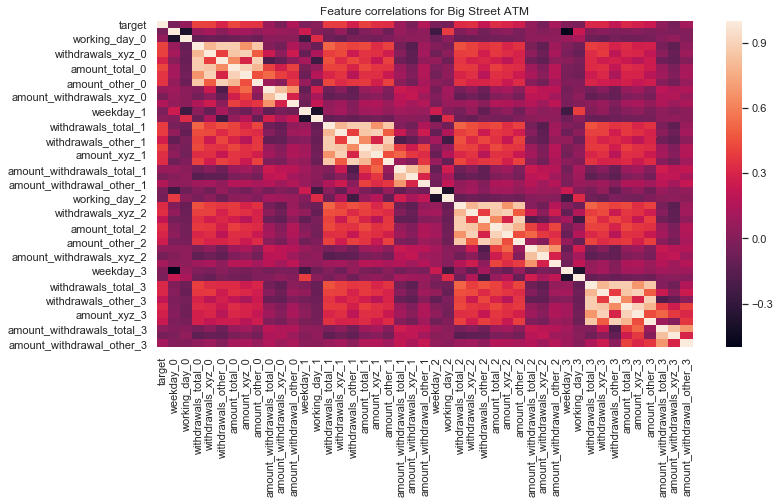

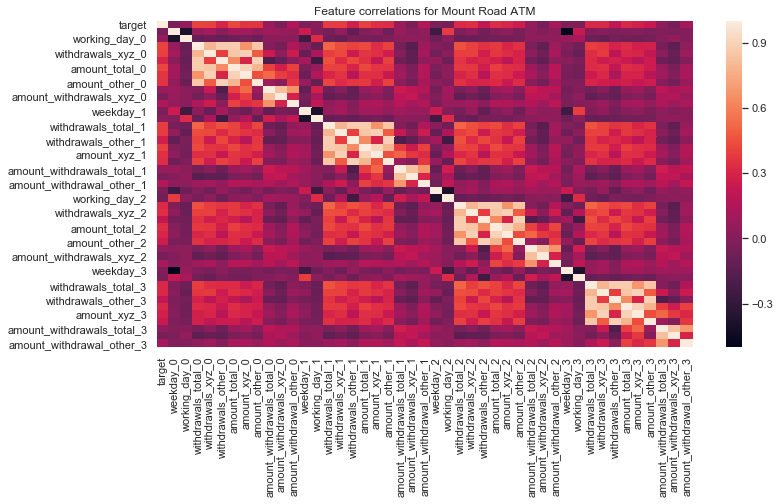

In [9]:
for atm in set(df.atm_name):
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_df.corr()).set_title(f'Feature correlations for {atm}')

## RMSE and prediction vs. actual value for the test set (last 1 year)

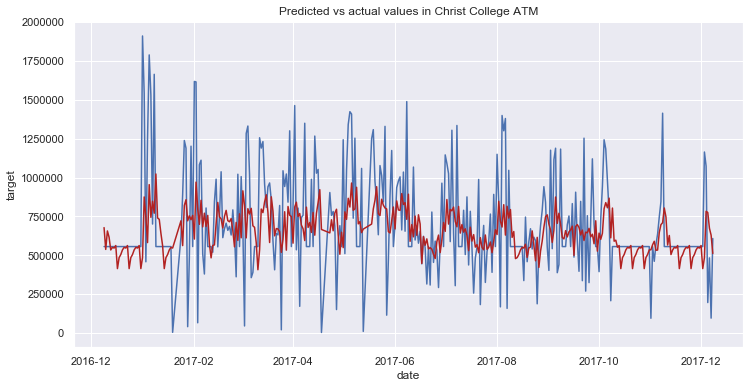

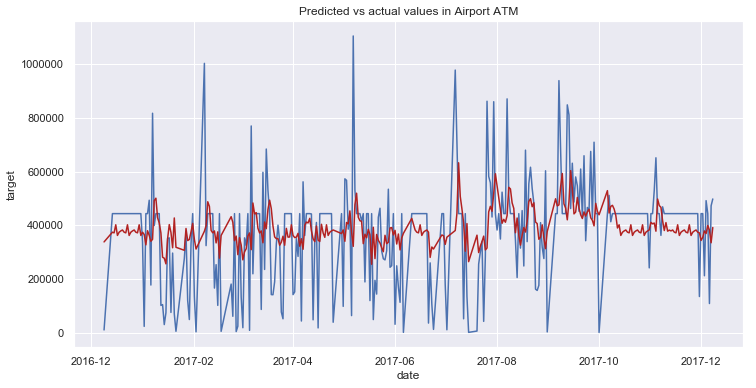

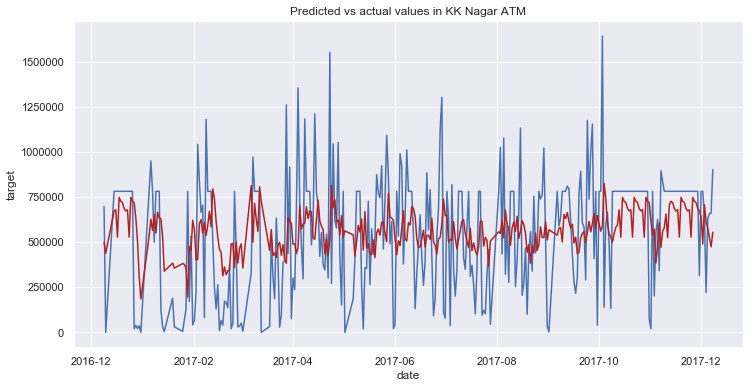

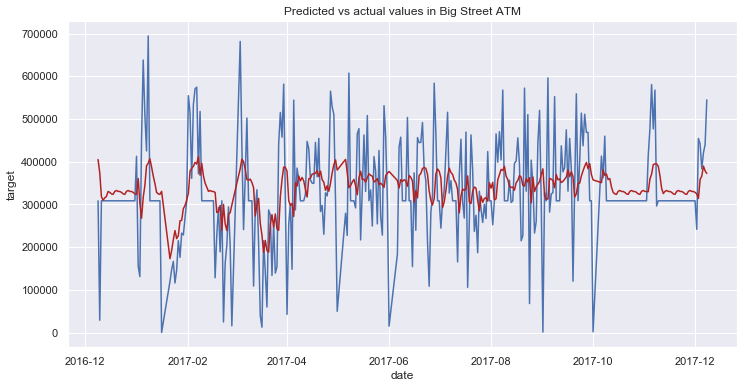

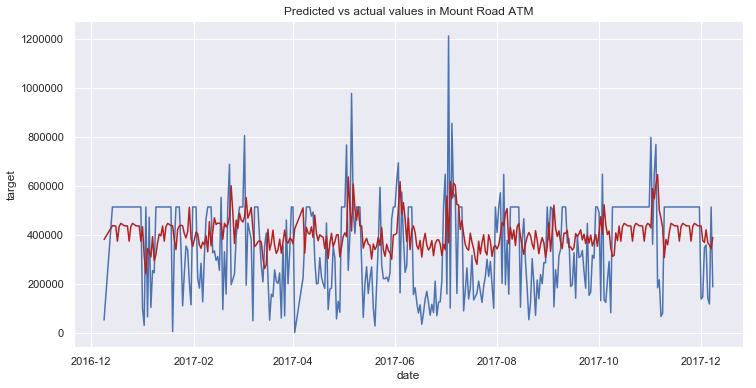

In [10]:
rmse = []

for atm in set(df.atm_name):
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=test_trues[atm].index, y=test_trues[atm])
    sns.lineplot(x=test_trues[atm].index, y=test_predictions[atm], color='firebrick').set_title(f'Predicted vs actual values in {atm}')
    
    rmse.append(
        np.mean(np.power(np.power(np.array(test_trues[atm]) - np.array(test_predictions[atm]), 2), 0.5))
    )

In [11]:
print(f'The ovarall RMSE is {sum(rmse) / len(rmse)}')

The ovarall RMSE is 169257.19981106604


## Example section below [Deprecated]

In [ ]:
# First ATM example

atm = 'Mount Road ATM'
temp = df[df.atm_name == atm]
    
features = {
    'target': temp.amount_total.astype('float').shift(-1),
    'atm_name': temp.atm_name
}
for depth in range(4):
    features_depth = create_historical_features(temp, depth)
    for key, value in features_depth.items():
        features[key] = value

train_df = train_df.append(pd.DataFrame(features))
train_df = train_df.sort_index().dropna()

train = train_df[train_df.index <= train_df.index.max() - dt.timedelta(days=365)]
test = train_df[train_df.index > train_df.index.max() - dt.timedelta(days=365)]

In [ ]:
train.target.plot(figsize=(20, 10))